In [1]:
from model import SugarscapeCg

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

## Helper functions

In [2]:
def run_model(model):
    model.run_model()

    output = model.datacollector.get_model_vars_dataframe()
    print(output)

    return output

In [3]:
def get_data(df, key):
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [4]:
def get_means_cis(data):
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

## Plotting functions

In [5]:
def plot_errorbars(means, cis, y_axis_label):
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [6]:
def plot_district_crimes(district_means, district_cis, district_names, district_colors):
    for district_index in range(len(district_means)):
        plt.errorbar(x=range(len(district_means[district_index])), y=district_means[district_index], yerr=district_cis[district_index], label=district_names[district_index], color=district_colors[district_index], ecolor=district_colors[district_index])
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [7]:
def plot_district_crimes_bar(district_means, district_cis, district_names, district_colors):
    plt.bar(np.arange(8), height=district_means, yerr=district_cis, color=district_colors, capsize=10)
    plt.xticks(np.arange(8), district_names)
    # plt.xlabel("Number of steps")
    plt.ylabel('Number of crimes')

## Run model

In [8]:
num_runs = 10
outputs = []

for run in range(num_runs):
    m = SugarscapeCg()
    output = run_model(m)
    outputs.append(output)

Initial number Sugarscape Agent:  710
[1, 1386.0]
[2, 1989.0]
[3, 2576.0]
[4, 3163.0]
[5, 3634.0]
[6, 4079.0]
[7, 4437.0]
[8, 4733.0]
[9, 4983.0]
[10, 5202.0]
[11, 5321.0]
[12, 5538.0]
[13, 5710.0]
[14, 5873.0]
[15, 6146.0]
[16, 6432.0]
[17, 6733.0]
[18, 7022.0]
[19, 7333.0]
[20, 7644.0]
[21, 8009.0]
[22, 8267.0]
[23, 8553.0]
[24, 8816.0]
[25, 9032.0]
[26, 9273.0]
[27, 9569.0]
[28, 9912.0]
[29, 10254.0]
[30, 10629.0]
[31, 11021.0]
[32, 11459.0]
[33, 11884.0]
[34, 12288.0]
[35, 12680.0]
[36, 13031.0]
[37, 13362.0]
[38, 13707.0]
[39, 14051.0]
[40, 14342.0]
[41, 14620.0]
[42, 14906.0]
[43, 15204.0]
[44, 15521.0]
[45, 15821.0]
[46, 16138.0]
[47, 16438.0]
[48, 16681.0]
[49, 16942.0]
[50, 17236.0]
[51, 17526.0]
[52, 17869.0]
[53, 18208.0]
[54, 18517.0]
[55, 18842.0]
[56, 19167.0]
[57, 19514.0]
[58, 19910.0]
[59, 20264.0]
[60, 20589.0]
[61, 20936.0]
[62, 21237.0]
[63, 21546.0]
[64, 21919.0]
[65, 22300.0]
[66, 22676.0]
[67, 23038.0]
[68, 23384.0]
[69, 23689.0]
[70, 24038.0]
[71, 24342.0]
[72, 

In [9]:
print(outputs[0])

     Criminal Wealth  Criminal Count  Criminal in Jail Count  Crimes commited  \
0              710.0              45                       0                0   
1             1386.0              45                       7               44   
2             1989.0              45                       9               81   
3             2576.0              45                       9              116   
4             3163.0              45                      15              151   
..               ...             ...                     ...              ...   
196          67114.0              45                      23             4250   
197          67482.0              45                      21             4271   
198          67907.0              45                      22             4294   
199          68320.0              45                      22             4316   
200          68718.0              45                      21             4338   

     Centrum  Noord  West  

## Plots

### Criminal wealths

In [10]:
all_wealths = get_data(outputs, 'Criminal Wealth')

# print(all_wealths[0])
print(all_wealths.shape)

(201, 10)


In [11]:
mean_wealths, cis_wealths = get_means_cis(all_wealths)

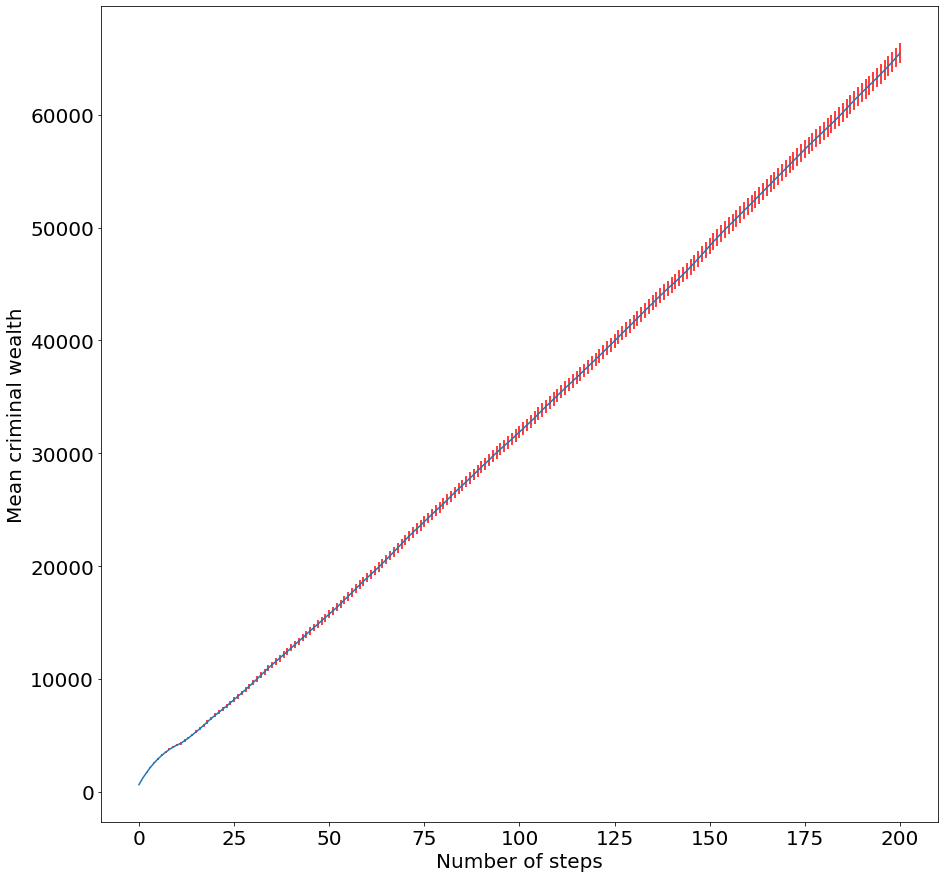

In [12]:
plot_errorbars(mean_wealths, cis_wealths, "Mean criminal wealth")

### Criminals in jail

In [13]:
jail_count = get_data(outputs, 'Criminal in Jail Count')

print(jail_count.shape)

(201, 10)


In [14]:
mean_jail_count, cis_jail_count = get_means_cis(jail_count)

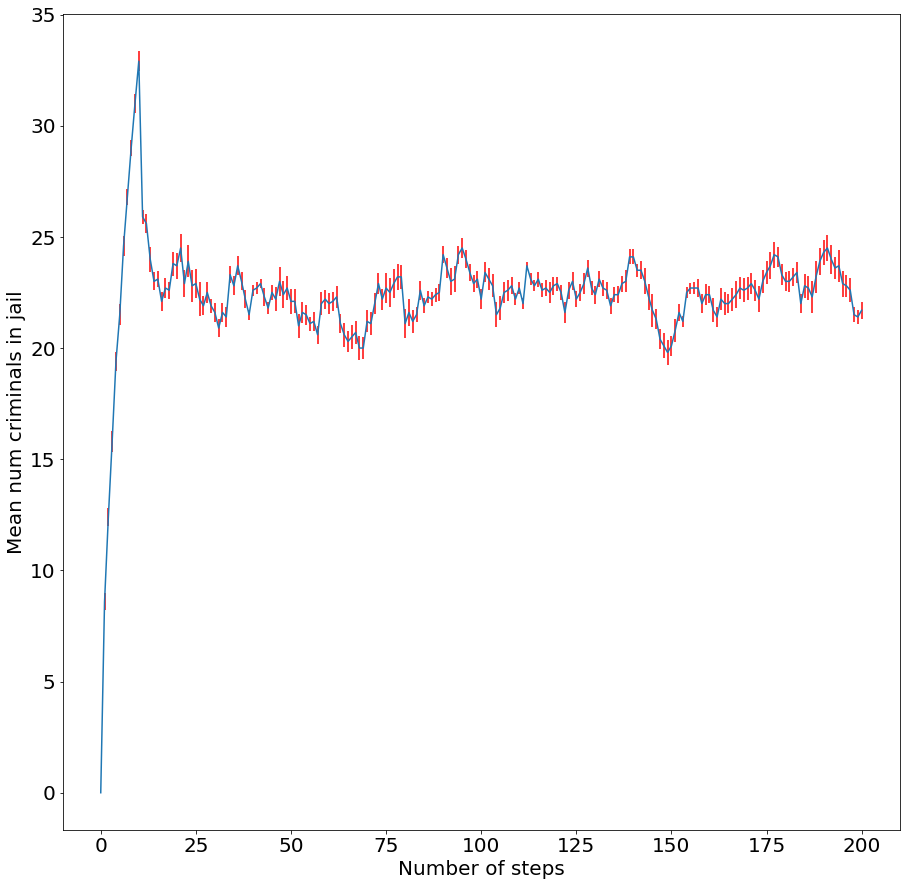

In [15]:
plot_errorbars(mean_jail_count, cis_jail_count, "Mean num criminals in jail")

### Crimes committed

In [16]:
crimes_count = get_data(outputs, 'Crimes commited')

print(crimes_count.shape)

(201, 10)


In [17]:
mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)

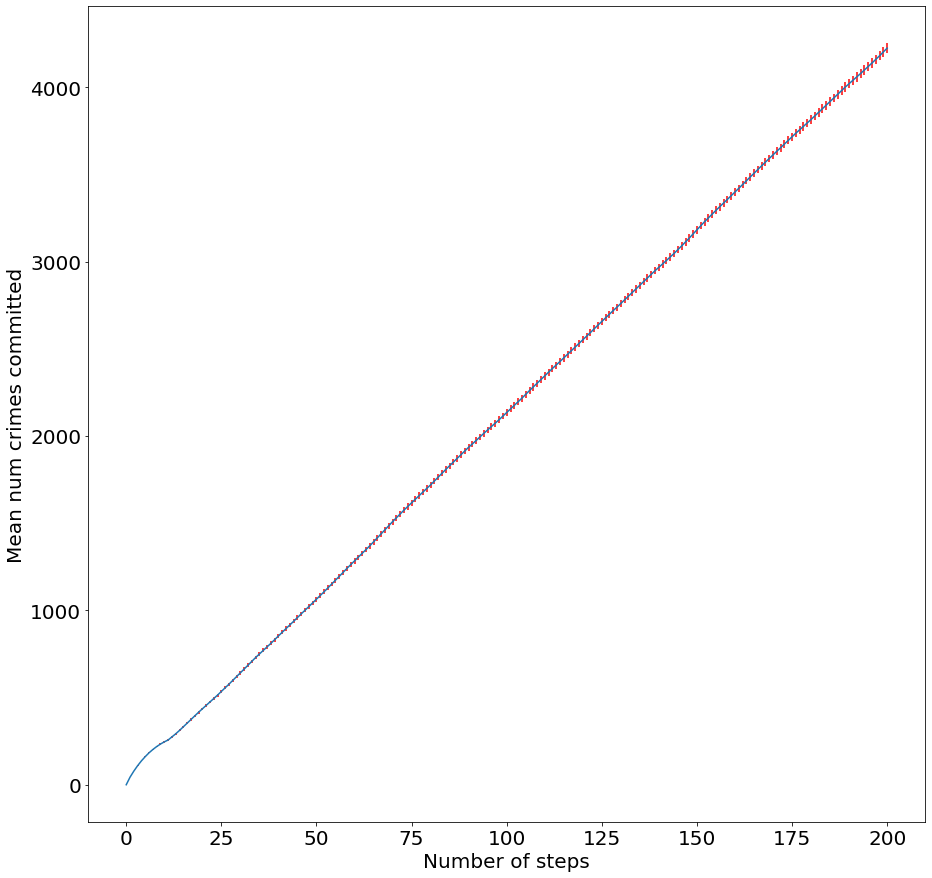

In [18]:
plot_errorbars(mean_crimes_count, cis_crimes_count, "Mean num crimes committed")

### District crimes

In [19]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
district_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'gray']

In [20]:
all_district_means = []
all_district_cis = []

for district in district_names:
    crimes_count = get_data(outputs, district)
    mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)
    all_district_means.append(mean_crimes_count)
    all_district_cis.append(cis_crimes_count)

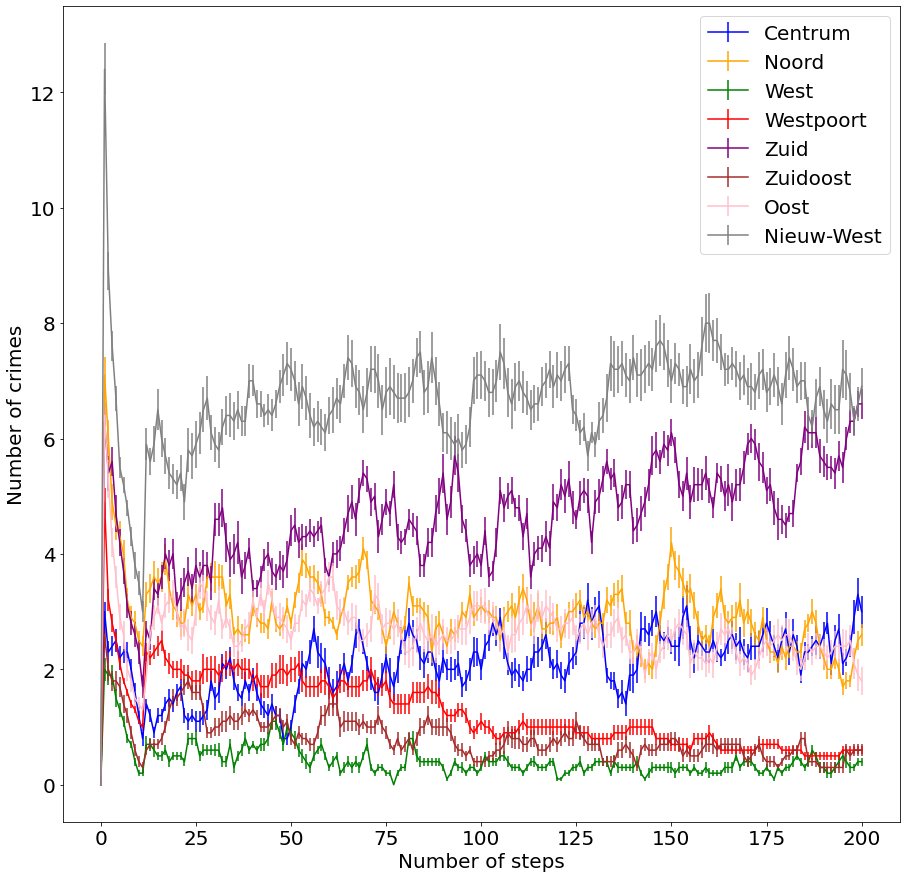

In [21]:
plot_district_crimes(all_district_means, all_district_cis, district_names, district_colors)

In [22]:
print(len(all_district_means))
print(len(all_district_means[0]))

final_district_means = []
for district in all_district_means:
    final_district_means.append(district[-1])

print(final_district_means)

final_district_cis = []
for district in all_district_cis:
    final_district_cis.append(district[-1])

print(final_district_cis)

8
201
[3.0, 2.6, 0.4, 0.6, 6.6, 0.6, 1.8, 6.9]
[0.2764954814165705, 0.18752835938102616, 0.06772728456557862, 0.06772728456557862, 0.25641136103856965, 0.11059819256662821, 0.24575455943397484, 0.3179698036290561]


In [23]:
# Sort by size
sorting = zip(final_district_means, district_names, district_colors)
final_district_means, district_names, district_colors = zip(*sorted(sorting, key=lambda x : x[0]))

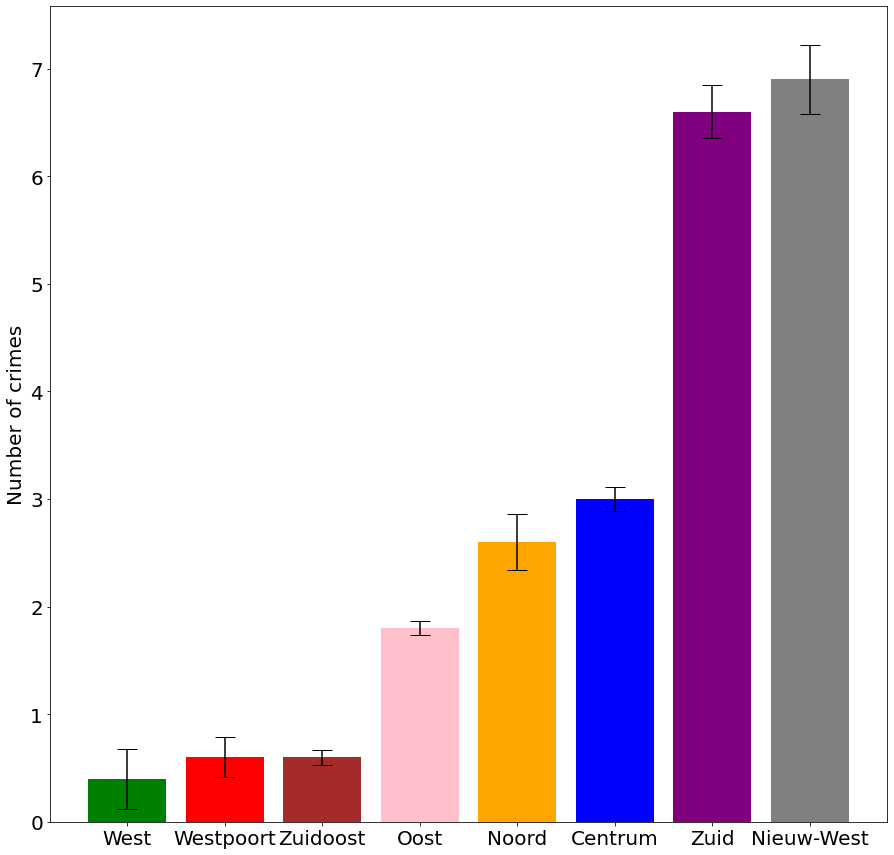

In [24]:
plot_district_crimes_bar(final_district_means, final_district_cis, district_names, district_colors)